[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/PreferredAI/tutorials/blob/master/recommender-systems/01_intro.ipynb)

# 1. Setup

In [0]:
!pip install --quiet cornac==1.4.1

In [0]:
import os
import sys

import cornac
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, sparse

%matplotlib inline

print(f"System version: {sys.version}")
print(f"Cornac version: {cornac.__version__}")

System version: 3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0]
Cornac version: 1.4.1


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 2. Data exploration

We are going to explore [MovieLens](https://grouplens.org/datasets/movielens/) dataset.  For the purpose of demonstration, we will use the small one with 100K ratings.  The dataset is built-in and can be loaded using Cornac library.  More datasets are available [here](https://github.com/PreferredAI/cornac/blob/master/cornac/datasets/README.md).

Most of the time we will see the dataset in recommendation being represented by a form of triplets (*user_id*, *item_id*, *rating*).  For this MovieLens dataset, we have rating values are in {1, 2, 3, 4, 5}.

In [0]:
data = cornac.datasets.movielens.load_feedback(variant="100K")
df = pd.DataFrame(data, columns=["user_id", "item_id", "rating"])
df.head()

,user_id,item_id,rating
0,196,242,3.0
1,186,302,3.0
2,22,377,1.0
3,244,51,2.0
4,166,346,1.0


In [0]:
print(f"Number of ratings: {len(df)}")
print(f"Number of users: {df.user_id.nunique()}")
print(f"Number of items: {df.item_id.nunique()}")

Number of ratings: 100000
Number of users: 943
Number of items: 1682


## Rating statistics

Let's see some basic statistics of the rating values.

In [0]:
df.rating.describe()

count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

We can plot rating values to see how it's being distributed.  

*   1st figure shows frequency of each rating.
*   2nd figure describes the distribution in the form of box plot.

Generally, more than 50% of the rating values lie between {3, 4}, rating 5 is also common, while {1, 2} are less likely. 

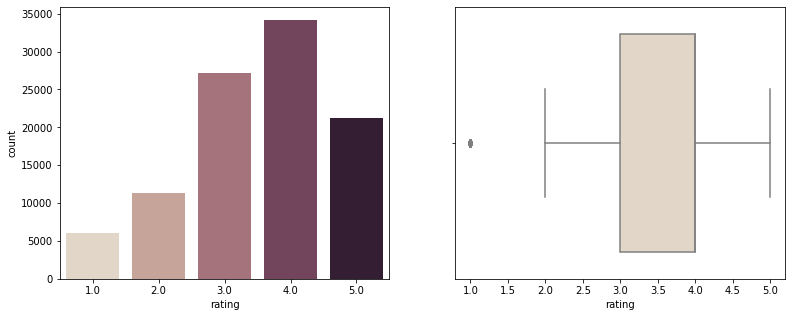

In [0]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))
sns.countplot(x="rating", data=df, palette="ch:.25", ax=axes[0])
sns.boxplot(x="rating", data=df, palette="ch:.25", ax=axes[1])

## Sparsity of the data

Data sparsity is one of the main challenge in recommender systems.  It arises from the phenomenom that a user only gives ratings to a limited number of items.  A lot of times we will see users having only one or a few interactions.

We measure the sparsity based on the number of available ratings and the size of rating matrix.

In [0]:
n_users = df.user_id.nunique()
n_items = df.item_id.nunique()
n_ratings = len(df)
rating_matrix_size = n_users * n_items
sparsity = 1 - n_ratings / rating_matrix_size

print(f"Number of users: {n_users}")
print(f"Number of items: {n_items}")
print(f"Number of available ratings: {n_ratings}")
print(f"Number of all possible ratings: {rating_matrix_size}")
print("-" * 40)
print(f"SPARSITY: {sparsity * 100.0:.2f}%")

Number of users: 943
Number of items: 1682
Number of available ratings: 100000
Number of all possible ratings: 1586126
----------------------------------------
SPARSITY: 93.70%


For the MovieLens dataset that we are working on, it's considered dense as each user having at least 20 ratings.  For a lot of other datasets, the sparsity is normally greater than 99%.  

## Power-Law distribution

In recommendation, another important phenomenom is a [power-law/long-tailed distribution](https://en.wikipedia.org/wiki/Power_law).  It implies that some of the items are very popular and frequently rated by users, while a lot of other items are rated by very few users.

First, we count the number of ratings by item.  As shown below the top 10 rated items.

In [22]:
item_rate_count = df.groupby("item_id")["user_id"].nunique().sort_values(ascending=False)
item_rate_count.head(10)

item_id
50     583
258    509
100    508
181    507
294    485
286    481
288    478
1      452
300    431
121    429
Name: user_id, dtype: int64

Let's see the list of 10 least rated items.  All of them are only rated by 1 user.

In [25]:
item_rate_count.tail(10)

item_id
1630    1
1632    1
1633    1
1634    1
1635    1
1352    1
1636    1
1637    1
1638    1
1669    1
Name: user_id, dtype: int64

Below we visualize the rating count information.

*   1st figure shows the rating frequency of items (sorted by the values).  We can easily observe the long-tailed shape discussed earlier.
*   2nd figure is the [log-log plot](https://en.wikipedia.org/wiki/Log%E2%80%93log_plot) showing the relationship between number of items and number of ratings in log scale.   The relationship is asymptotically linear, which is the main characteristic of a power-law distribution.



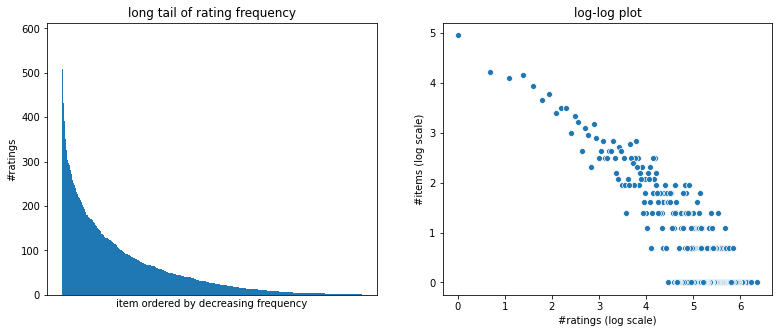

In [0]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))

axes[0].bar(x=item_rate_count.index, height=item_rate_count.values, width=1.0, align="edge")
axes[0].set_xticks([])
axes[0].set(title="long tail of rating frequency", 
            xlabel="item ordered by decreasing frequency", 
            ylabel="#ratings")

count = item_rate_count.value_counts()
sns.scatterplot(x=np.log(count.index), y=np.log(count.values), ax=axes[1])
axes[1].set(title="log-log plot", xlabel="#ratings (log scale)", ylabel="#items (log scale)");

# 3. Recommendation based on item popularity

As we discussed earlier that some items are much more popular than the rest.  It reflects the fact that some of the items are mutually liked by a majority of users.  From that observation, it inspires a very simple approach for providing recommendations based on popularity (i.e., number of ratings) of the items.   

Let's do a simple experiment with the popularity approach.  In this experiment, we will split data into 5 folds for cross-validation.  For each run, 4 folds will be used for training and the other fold will be used for evaluation. 

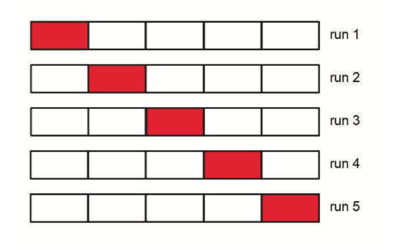

In [29]:
# 5-fold cross validation
eval_method = cornac.eval_methods.CrossValidation(data, n_folds=5, seed=42)

# recommender system based on item popularity
most_pop = cornac.models.MostPop()

# recall@20 measurement
rec_20 = cornac.metrics.Recall(k=20)

# put everything together into an experiment
cornac.Experiment(eval_method=eval_method, models=[most_pop], metrics=[rec_20]).run()


TEST:
...
[MostPop]
       | Recall@20 | Train (s) | Test (s)
------ + --------- + --------- + --------
Fold 0 |    0.1263 |    0.0055 |   0.4423
Fold 1 |    0.1304 |    0.0054 |   0.4054
Fold 2 |    0.1337 |    0.0054 |   0.4065
Fold 3 |    0.1252 |    0.0054 |   0.4255
Fold 4 |    0.1187 |    0.0054 |   0.4178
------ + --------- + --------- + --------
Mean   |    0.1269 |    0.0054 |   0.4195
Std    |    0.0051 |    0.0000 |   0.0136

